In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/train', transform=train_transform)
val_dataset = ImageFolder(root='D:/Refined 7 Dataset/RICE KAGGLE/test', transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
# Define the combined model
class Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(Ensemble, self).__init__()

        # Initialize VGG16 and ViT models
        vgg16 = models.vgg16(weights=True)
        self.vgg16 = nn.Sequential(*list(vgg16.features.children()))

        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        self.vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                              num_labels=num_classes,
                                                              ignore_mismatched_sizes=True)

        for param in self.vit_model.vit.encoder.parameters():
            param.requires_grad = False

        for param in self.vit_model.classifier.parameters():
            param.requires_grad = False
        
        self.conv_reduce = nn.Conv2d(512, 3, kernel_size=1)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def forward(self, x):
        vgg_features = self.vgg16(x)
        reduced_features = self.conv_reduce(vgg_features)
        vit_input = self.upsample(reduced_features)
        vit_output = self.vit_model(pixel_values=vit_input).logits
        return vit_output

In [4]:
# Initialize model, loss, optimizer, and device
num_classes = len(train_dataset.classes)
model = Ensemble(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr=1e-4,
                       betas = (0.9, 0.9),
                       weight_decay=0.01)

C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [5]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of trainable parameters: 745731


In [6]:
# Training and validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
num_epochs = 30
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Training phase
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    train_bar = tqdm(train_loader, desc="Training")
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_bar.set_postfix(loss=running_loss / total_train, accuracy=100 * correct_train / total_train)

    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_bar.set_postfix(loss=val_loss / total_val, accuracy=100 * correct_val / total_val)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {avg_train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {avg_val_accuracy:.2f}%")

end_time = time.time()

Epoch [1/30]


Training:   0%|                                                                                | 0/127 [00:00<?, ?it/s]C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
Training: 100%|██████████████████████████████████████████| 127/127 [02:11<00:00,  1.03s/it, accuracy=54.8, loss=0.0305]


Epoch [1/30] - Train Loss: 0.9756, Train Accuracy: 54.79%, Val Loss: 0.8929, Val Accuracy: 64.57%
Epoch [2/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=69.6, loss=0.0252]


Epoch [2/30] - Train Loss: 0.8064, Train Accuracy: 69.58%, Val Loss: 0.7826, Val Accuracy: 70.05%
Epoch [3/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=75.4, loss=0.0214]


Epoch [3/30] - Train Loss: 0.6838, Train Accuracy: 75.39%, Val Loss: 0.7004, Val Accuracy: 74.88%
Epoch [4/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=79.9, loss=0.0187]


Epoch [4/30] - Train Loss: 0.5990, Train Accuracy: 79.94%, Val Loss: 0.6398, Val Accuracy: 77.13%
Epoch [5/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=82.6, loss=0.0167]


Epoch [5/30] - Train Loss: 0.5330, Train Accuracy: 82.65%, Val Loss: 0.6054, Val Accuracy: 77.94%
Epoch [6/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=85.6, loss=0.0148]


Epoch [6/30] - Train Loss: 0.4740, Train Accuracy: 85.58%, Val Loss: 0.5440, Val Accuracy: 81.00%
Epoch [7/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=88.3, loss=0.0133]


Epoch [7/30] - Train Loss: 0.4252, Train Accuracy: 88.28%, Val Loss: 0.4900, Val Accuracy: 84.06%
Epoch [8/30]


Training: 100%|████████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=90, loss=0.0118]


Epoch [8/30] - Train Loss: 0.3788, Train Accuracy: 90.03%, Val Loss: 0.4398, Val Accuracy: 86.47%
Epoch [9/30]


Training: 100%|████████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=92, loss=0.0107]


Epoch [9/30] - Train Loss: 0.3419, Train Accuracy: 91.98%, Val Loss: 0.3905, Val Accuracy: 88.41%
Epoch [10/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=92.9, loss=0.00985]


Epoch [10/30] - Train Loss: 0.3150, Train Accuracy: 92.86%, Val Loss: 0.3824, Val Accuracy: 89.53%
Epoch [11/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=94.2, loss=0.00906]


Epoch [11/30] - Train Loss: 0.2899, Train Accuracy: 94.24%, Val Loss: 0.3278, Val Accuracy: 91.63%
Epoch [12/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=95.2, loss=0.00823]


Epoch [12/30] - Train Loss: 0.2632, Train Accuracy: 95.23%, Val Loss: 0.3201, Val Accuracy: 92.11%
Epoch [13/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=95.8, loss=0.0077]


Epoch [13/30] - Train Loss: 0.2462, Train Accuracy: 95.79%, Val Loss: 0.3036, Val Accuracy: 92.75%
Epoch [14/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=95.9, loss=0.00719]


Epoch [14/30] - Train Loss: 0.2300, Train Accuracy: 95.94%, Val Loss: 0.2689, Val Accuracy: 94.69%
Epoch [15/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=96.3, loss=0.00683]


Epoch [15/30] - Train Loss: 0.2186, Train Accuracy: 96.28%, Val Loss: 0.2551, Val Accuracy: 94.20%
Epoch [16/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=96.8, loss=0.00634]


Epoch [16/30] - Train Loss: 0.2029, Train Accuracy: 96.85%, Val Loss: 0.2416, Val Accuracy: 95.97%
Epoch [17/30]


Training: 100%|███████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=97, loss=0.00594]


Epoch [17/30] - Train Loss: 0.1900, Train Accuracy: 97.05%, Val Loss: 0.2291, Val Accuracy: 95.33%
Epoch [18/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=97.3, loss=0.00563]


Epoch [18/30] - Train Loss: 0.1801, Train Accuracy: 97.32%, Val Loss: 0.2167, Val Accuracy: 95.65%
Epoch [19/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=97.4, loss=0.00554]


Epoch [19/30] - Train Loss: 0.1771, Train Accuracy: 97.42%, Val Loss: 0.2212, Val Accuracy: 95.17%
Epoch [20/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=97.4, loss=0.00526]


Epoch [20/30] - Train Loss: 0.1682, Train Accuracy: 97.44%, Val Loss: 0.1969, Val Accuracy: 96.46%
Epoch [21/30]


Training: 100%|███████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98, loss=0.00493]


Epoch [21/30] - Train Loss: 0.1579, Train Accuracy: 98.03%, Val Loss: 0.1859, Val Accuracy: 96.78%
Epoch [22/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.1, loss=0.00468]


Epoch [22/30] - Train Loss: 0.1497, Train Accuracy: 98.08%, Val Loss: 0.1925, Val Accuracy: 95.49%
Epoch [23/30]


Training: 100%|██████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.5, loss=0.0043]


Epoch [23/30] - Train Loss: 0.1376, Train Accuracy: 98.47%, Val Loss: 0.1597, Val Accuracy: 97.91%
Epoch [24/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.2, loss=0.00438]


Epoch [24/30] - Train Loss: 0.1403, Train Accuracy: 98.15%, Val Loss: 0.1995, Val Accuracy: 95.49%
Epoch [25/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.4, loss=0.00422]


Epoch [25/30] - Train Loss: 0.1351, Train Accuracy: 98.40%, Val Loss: 0.2168, Val Accuracy: 93.40%
Epoch [26/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.6, loss=0.00393]


Epoch [26/30] - Train Loss: 0.1256, Train Accuracy: 98.62%, Val Loss: 0.1389, Val Accuracy: 98.39%
Epoch [27/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.8, loss=0.00375]


Epoch [27/30] - Train Loss: 0.1201, Train Accuracy: 98.84%, Val Loss: 0.1366, Val Accuracy: 98.87%
Epoch [28/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:10<00:00,  1.03s/it, accuracy=98.7, loss=0.00386]


Epoch [28/30] - Train Loss: 0.1234, Train Accuracy: 98.72%, Val Loss: 0.1397, Val Accuracy: 98.55%
Epoch [29/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:11<00:00,  1.04s/it, accuracy=98.7, loss=0.00386]


Epoch [29/30] - Train Loss: 0.1235, Train Accuracy: 98.72%, Val Loss: 0.1364, Val Accuracy: 98.39%
Epoch [30/30]


Training: 100%|█████████████████████████████████████████| 127/127 [02:12<00:00,  1.05s/it, accuracy=98.8, loss=0.00376]
                                                                                                                       

Epoch [30/30] - Train Loss: 0.1202, Train Accuracy: 98.77%, Val Loss: 0.1355, Val Accuracy: 98.39%


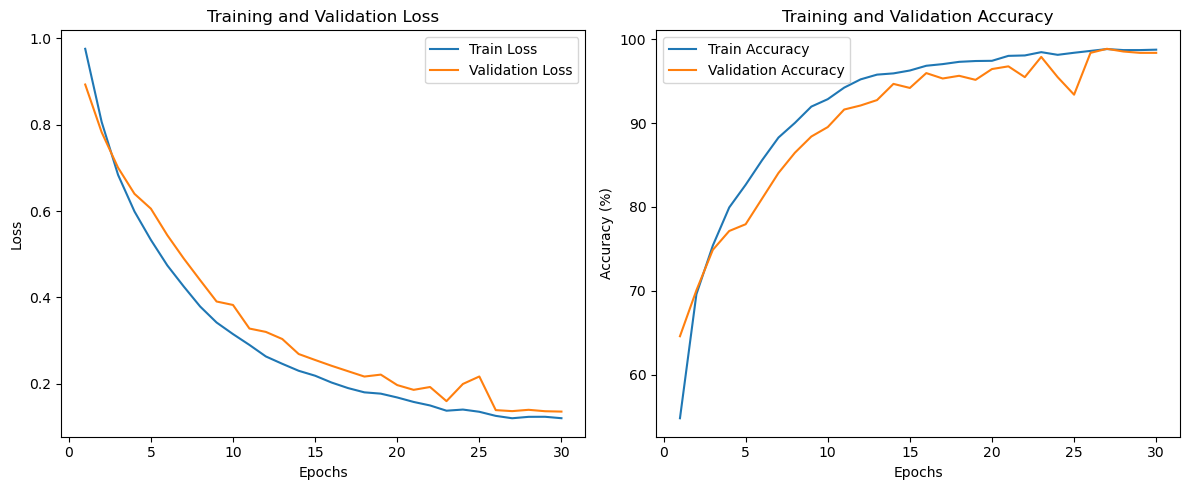

Total Training Time: 73.02 minutes


In [7]:
# Plot results
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")